#### Importing Necessary Packages

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading & Preping the Dataset

In [74]:
df = pd.read_csv("groceries_dataset.csv")
# checking the state of our data set
print("Checking the Info in the data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
df.info() 
print("\nChecking for null values ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
df.isnull().sum().sort_values(ascending=False)
print("\nChecking the first 3 values of our data~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(df.head(3))

# Changing the date type in a new column
df['date'] = pd.to_datetime(df["Date"])
print("\nChecking the Info after type conversion~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
df.info() 

Checking the Info in the data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB

Checking for null values ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Checking the first 3 values of our data~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Member_number        Date itemDescription
0           1808  21-07-2015  tropical fruit
1           2552  05-01-2015      whole milk
2           2300  19-09-2015       pip fruit

Checking the Info after type conversion~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column           Non-Null Count  D

#### Plotting the top 10 sold items

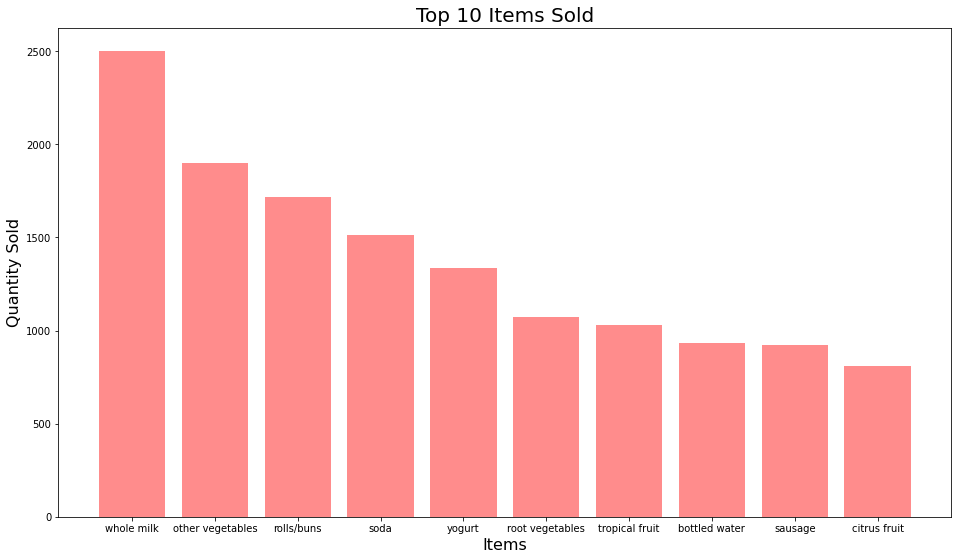

In [75]:
item_distr = df.groupby(by='itemDescription').size().reset_index(name='Frequency').sort_values(by='Frequency', ascending=False).head(10)

bars = item_distr["itemDescription"]
height = item_distr["Frequency"]
x_pos = np.arange(len(bars))

plt.figure(figsize=(16,9))
plt.bar(x_pos, height=height, color=(1, 0.1, 0.1, 0.5))
plt.title("Top 10 Items Sold", fontsize=20)
plt.xlabel("Items", fontsize=16)
plt.ylabel("Quantity Sold", fontsize=16)
plt.xticks(x_pos, bars)
plt.show()

[Text(0, 0.5, '# of item sold'), Text(0.5, 0, 'date')]

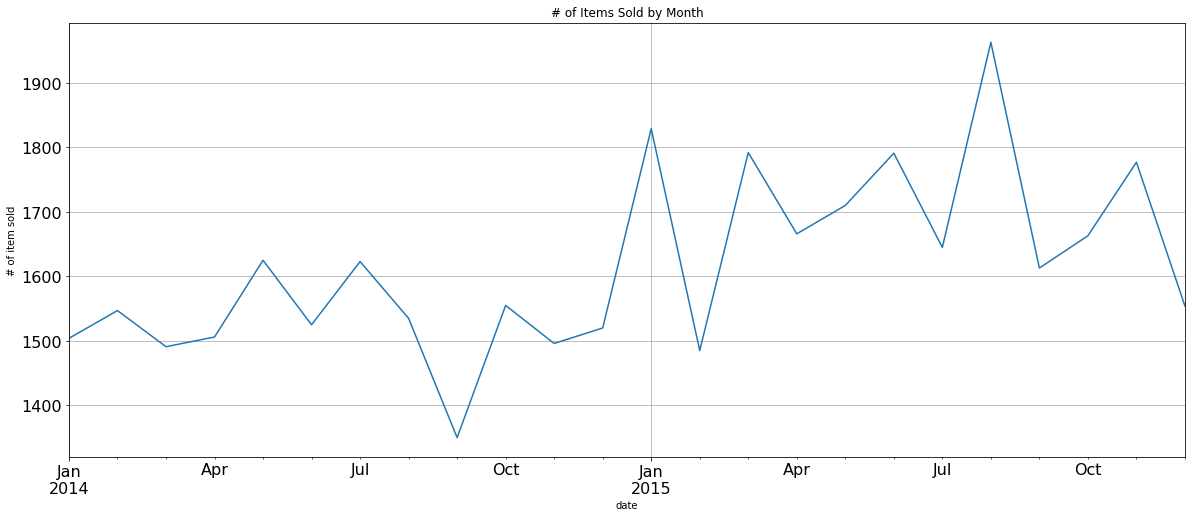

In [76]:
new_df = df.set_index(['date']) # creating dataframe with Date as the index
new_df.resample("M")["itemDescription"].count().plot(figsize=(20,8), fontsize=16, grid=True, title='# of Items Sold by Month').set(xlabel="date", ylabel="# of item sold")

#### Selecting data for Modeling

In [77]:
# sorting by member purchases and removing white spaces
customer_items = df[["Member_number", "itemDescription"]].sort_values(by="Member_number", ascending=False)
customer_items["itemDescription"] = customer_items["itemDescription"].str.strip()
customer_items

,Member_number,itemDescription
3578,5000,soda
34885,5000,semi-finished bread
11728,5000,fruit/vegetable juice
9340,5000,bottled beer
19727,5000,root vegetables
...,...,...
13331,1000,whole milk
17778,1000,pickled vegetables
6388,1000,sausage
20992,1000,semi-finished bread


In [78]:
# changing the items to list format
transactions = [a[1]["itemDescription"].tolist() for a in list(customer_items.groupby(["Member_number"]))]
transactions[0] # items bought by first customer

['misc. beverages',
 'sausage',
 'soda',
 'yogurt',
 'salty snack',
 'pastry',
 'canned beer',
 'hygiene articles',
 'whole milk',
 'pickled vegetables',
 'sausage',
 'semi-finished bread',
 'whole milk']

#### Implementing the Apyori Model

In [79]:
#!pip install apyori
from apyori import apriori
rules = apriori(transactions=transactions, min_support=0.002, min_confidence=0.05, min_lift=3, min_length=2)
results = list(rules)

def formatResults(results):
  '''Formats the results'''
  lhs = [tuple(result[2][0][0])[0] for result in results]
  rhs = [tuple(result[2][0][1])[0] for result in results]
  supports = [result[1] for result in results]
  confidences = [result[2][0][2] for result in results]
  lifts = [result[2][0][3] for result in results]
  return list(zip(lhs, rhs, supports, confidences, lifts))

results_df = pd.DataFrame(formatResults(results), columns = ["Left Hand Side", "Right Hand Side", "Support", "Confidence", "Lifts"])
results_df

,Left Hand Side,Right Hand Side,Support,Confidence,Lifts
0,kitchen towels,UHT-milk,0.002309,0.300000,3.821569
1,potato products,beef,0.002565,0.454545,3.802185
2,canned fruit,coffee,0.002309,0.428571,3.728954
3,meat spreads,domestic eggs,0.003592,0.400000,3.004239
4,flour,mayonnaise,0.002309,0.063380,3.338599
...,...,...,...,...,...
5341,sausage,rolls/buns,0.002565,0.052083,5.800595
5342,rolls/buns,whole milk,0.002309,0.062937,3.661622
5343,other vegetables,whole milk,0.002052,0.079208,4.608246
5344,rolls/buns,whole milk,0.002052,0.087912,5.114647


###### credits: https://www.youtube.com/watch?v=aqsa-gO_aq4&t=175s